In [2]:
import glob, sys
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

In [3]:
sys.path.append("..")
sam = sam_model_registry["vit_b"](checkpoint="checkpoints/sam_vit_h_4b8939.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
sam.to(device)
predictor = SamPredictor(sam)
predictor

# 1-Data preparation

In [20]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [42]:
def yolo2cv(bbox): 
    # In function calls, the asterisk (*) can be used to unpack a list or tuple into individual arguments
    #Bu yerda list comprehensiondan chiqqan 4 ta qiymatni x, y, w, h argument sifatida jonatyapti.
    return get_coordinates(*[float(bb) for bb in bbox.split(" ")[1:]])


def get_coordinates(x, y, w, h):
    """ This function formula converts [0, 1] range YOLO format to OpenCV format"""
    return [int((x - (w / 2)) * 640), 
            int((y - (h / 2)) * 640), 
            int((x + (w / 2)) * 640), 
            int((y + (h / 2)) * 640)]

def segment_image(image, input_boxes):
    predictor.set_image(image)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,)
    return masks 

segmented_data = []

for i, img_path in enumerate(tqdm.tqdm(glob.glob("data/test/images/*"))): 
    # if i == 10:  break
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[0], img.shape[1]
    bbox_path = img_path.replace('images', 'labels').replace(".jpg", ".txt")
    bboxes = open(bbox_path, mode='r').read().split("\n")[:-1] #rasmdagi har bir obyektni bboxini nextline boyicha olish
    if len(bboxes) < 1: continue #rasmda object umuman yoq holatda   
    #har bir boxga kiradi va yolo2cv2 funksiyasini chaqirib -> u esa har bir box x,y,w,h cordinatani olib
    #opencv formatga formula orqali o'tkazadi otkazadi va qaytaradi
    bbox_coordinates = []
    for bbox in bboxes: 
        bbox_coordinates.append(yolo2cv(bbox))
    
    input_boxes = torch.tensor(bbox_coordinates, device = predictor.device)
    masks = segment_image(image=img, input_boxes = input_boxes)
    segmented_data.append((img, masks))

100%|██████████| 67/67 [00:10<00:00,  6.57it/s]


In [52]:
import numpy as np
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=3))    

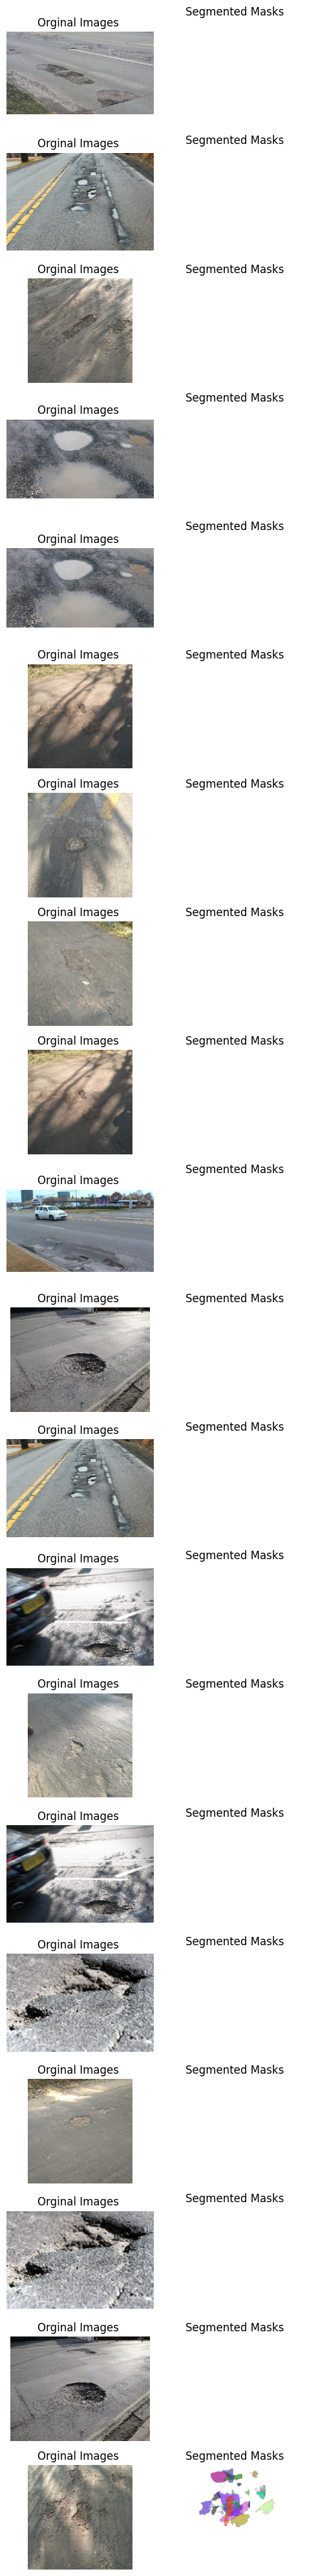

In [51]:
import random
random_indexs = [random.randint(0, len(segmented_data) - 1) for _ in range(20)]

def _show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image 

# Create figure and subplots (side-by-side in this example)
fig, axes = plt.subplots(len(random_indexs), 2, figsize=(5, len(random_indexs)*2))  # Adjust figsize as needed 
# Loop through image and labels and plot
for i, idx in enumerate(random_indexs): 
  img, masks = segmented_data[idx]
  axes[i, 0].imshow(img)
  for mask in masks:
    mask = _show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
  axes[i, 0].set_title(f"Orginal Images ")
  axes[i, 1].set_title(f"Segmented Masks ")
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


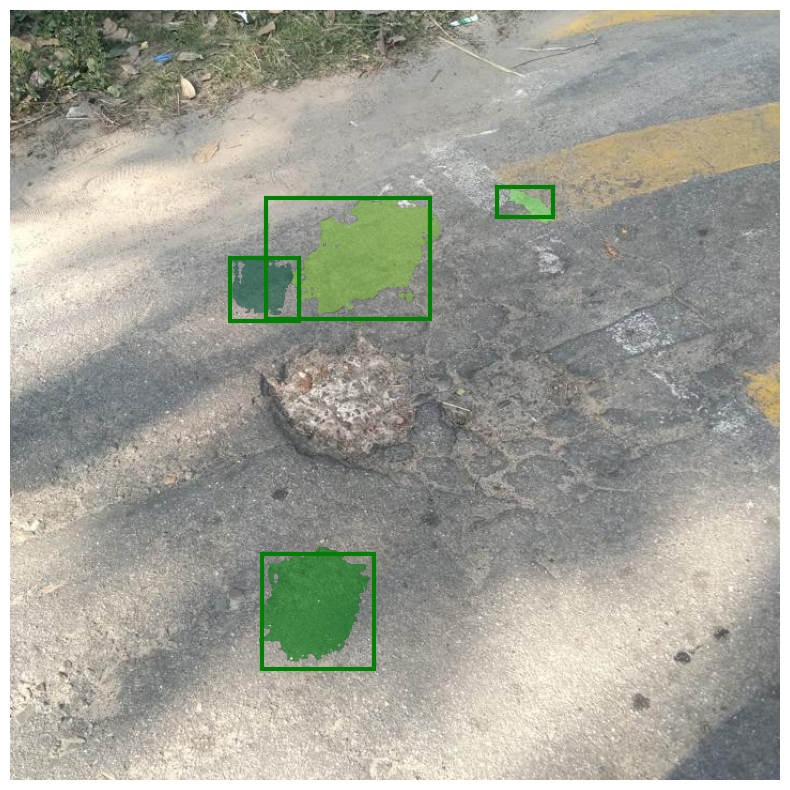

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()